In [62]:
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview

from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import maps
import utils
import selection_function_map as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [46]:
cmap_anim = utils.shiftedColorMap(matplotlib.cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0)
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0)
cmap_hist = utils.shiftedColorMap(matplotlib.cm.inferno_r, start=0.1, midpoint=0.55, stop=1.0)

color_gaia = 'purple'

In [48]:
name_catalog = '\emph{{Gaia}}-\emph{{unWISE}} Quasar Catalog'
abbrv_catalog = 'Quaia'

name_gpurer = "\emph{{Gaia}} DR3 Quasars `Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 `Purer'"

name_gall = "\emph{{Gaia}} DR3 Quasar Candidates"
abbrv_gall = "\emph{{Gaia}} DR3 Quasar Candidates"

name_sqall = "SDSS DR16Q Quasars"
abbrv_sqall = "SDSS DR16Q Quasars"

In [49]:
name_zgaia = "\emph{{Gaia}} redshift" 
abbrv_zgaia = "z_\mathrm{Gaia}"

name_zsdss = "\emph{{SDSS}} redshift" 
abbrv_zsdss = "z_\mathrm{SDSS}"

name_zspz = f"{abbrv_catalog} redshift" 
abbrv_zspz = f"z_\mathrm{{{abbrv_catalog}}}"

## Parameters

In [4]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

In [5]:
name_catalog = '\emph{{Gaia}}-\emph{{unWISE}} Quasar Catalog'
abbrv_catalog = 'Quaia'

In [6]:
G_hi = 20.5
G_lo = 20.0

In [7]:
fn_gcatlo = f'../data/quaia_G20.0.fits'
fn_gcathi = f'../data/quaia_G20.5.fits'

fn_sello = f"../data/maps/selection_function_NSIDE64_G20.0.fits"
fn_selhi = f"../data/maps/selection_function_NSIDE64_G20.5.fits"

In [8]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
fn_mcsmap = f'../data/maps/map_mcs_NSIDE{NSIDE}.npy'

In [9]:
map_dust = np.load(fn_dustmap)
map_stars = np.load(fn_starmap)
map_m10 = np.load(fn_m10map)
map_mcs = np.load(fn_mcsmap)

## Load and plot data

In [10]:
tab_gcatlo = Table.read(fn_gcatlo)
N_gcatlo = len(tab_gcatlo)
print(f"Number of data sources: {N_gcatlo}")

Number of data sources: 755850


In [11]:
pixel_indices_gcatlo = hp.ang2pix(NSIDE, tab_gcatlo['ra'], tab_gcatlo['dec'], lonlat=True)
map_gcatlo = np.bincount(pixel_indices_gcatlo, minlength=NPIX)

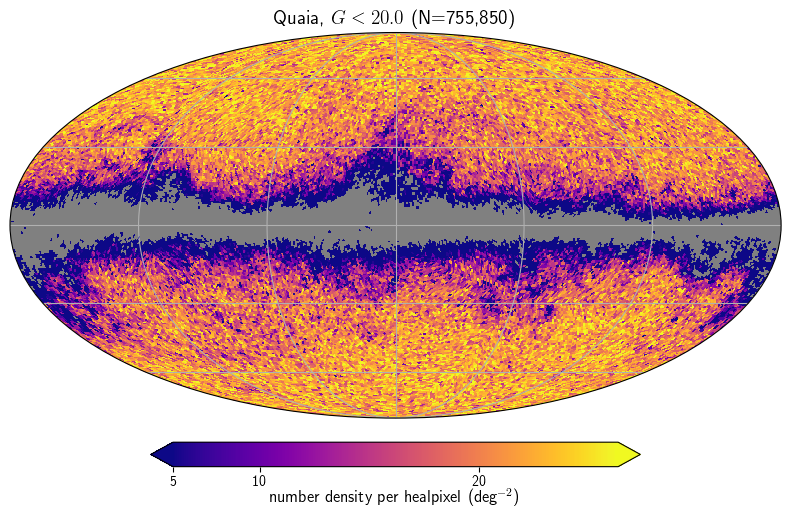

In [12]:
title_gcatlo = rf"Quaia, $G<{G_lo}$ (N={len(tab_gcatlo):,})"
projview(map_gcatlo, title=title_gcatlo,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_gcatlo)-np.std(map_gcatlo), max=np.median(map_gcatlo)+1.5*np.std(map_gcatlo), 
            norm='log', graticule=True,
            cbar_ticks=[5, 10, 20]) 

## Redshift analysis vs SDSS

In [37]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 243206
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [38]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [39]:
idx_Glo_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_lo

In [40]:
idx_Ghi_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_hi

In [42]:
z_sdss_test = tab_spz_labeled['z_sdss'][i_test]
z_spzraw_test = tab_spz_labeled['redshift_spz_raw'][i_test]
z_spz_test = tab_spz_labeled['redshift_spz'][i_test]
z_gaia_test = tab_spz_labeled['redshift_qsoc'][i_test]

In [43]:
dz_spzraw_test = (z_spzraw_test - z_sdss_test)/(1+z_sdss_test)
dz_spz_test = (z_spz_test - z_sdss_test)/(1+z_sdss_test)
dz_gaia_test = (z_gaia_test - z_sdss_test)/(1+z_sdss_test)

In [44]:
z_bins = np.linspace(0, np.max(z_gaia_test), 200)

Text(0, 0.5, '$z_\\mathrm{Quaia}$, Quaia redshift')

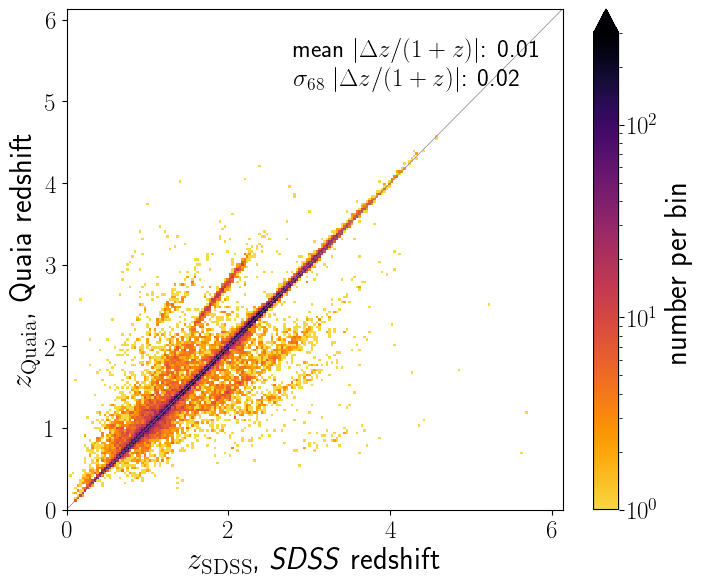

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_spz_test[idx_Ghi_test], bins=z_bins, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmin=1, vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin', extend='max')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

# text
mean = np.mean(dz_spz_test)
p16 = np.percentile(dz_spz_test, 16)
p84 = np.percentile(dz_spz_test, 84)
sigma = 0.5*(p84-p16)
text = rf'mean $|\Delta z/(1+z)|$: {mean:.2f}' + '\n' + \
       rf'$\sigma_{{68}}$ $|\Delta z/(1+z)|$: {sigma:.2f} '
plt.text(2.8, 5.2, text, fontsize=18)

plt.xlabel(rf'${abbrv_zsdss}$, {name_zsdss}')
plt.ylabel(rf'${abbrv_zspz}$, {name_zspz}')

### dz error cumulative histograms

In [51]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

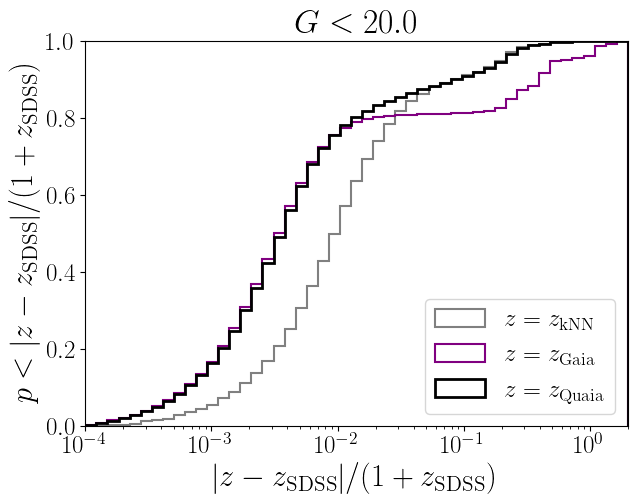

In [53]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_lo}$', fontsize=24)
lw=1.5
plt.hist(abs(dz_spzraw_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{kNN}$')
plt.hist(abs(dz_gaia_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color=color_gaia, label=rf'$z={abbrv_zgaia}$')
plt.hist(abs(dz_spz_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2,
         color='k', label=rf'$z={abbrv_zspz}$')
plt.xlabel(rf'$|z-{abbrv_zsdss}|/(1+{abbrv_zsdss})$')
plt.ylabel(rf'$p < |z-{abbrv_zsdss}|/(1+{abbrv_zsdss})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

In [59]:
quants = {}

In [56]:
dz_threshs = {'dzlo': 0.01, 'dzmid': 0.1, 'dzhi': 0.2}
G_maxs = {'Gbright': 19.0, 'Glo': 20.0, 'Ghi': 20.5}
dz_arrs = {'zspz': dz_spz_test, 'zgaia': dz_gaia_test}

In [57]:
# also save values to dict with full precision
frac_outliers_dict = {}

In [60]:
for G_name, G_max in G_maxs.items():
    quants[G_name] = G_max
    for dz_thresh_name, dz_thresh in dz_threshs.items():
        quants[dz_thresh_name] = dz_thresh
        for z_name, dz_arr in dz_arrs.items():
        
            i_G = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_max
            i_outliers = np.abs(dz_arr[i_G]) > dz_thresh
            key = f'p_outliers_{z_name}_{dz_thresh_name}_{G_name}'
            frac = np.sum(i_outliers)/len(i_outliers)
            val = f"{100*frac:.0f}"
            print(key, val)
            quants[key] = val
            frac_outliers_dict[key] = frac

            i_acc = np.abs(dz_arr[i_G]) <= dz_thresh
            key = f'p_acc_{z_name}_{dz_thresh_name}_{G_name}'
            frac = np.sum(i_acc)/len(i_acc)
            val = f"{100*frac:.0f}"
            print(key, val)
            quants[key] = val

p_outliers_zspz_dzlo_Gbright 12
p_acc_zspz_dzlo_Gbright 88
p_outliers_zgaia_dzlo_Gbright 10
p_acc_zgaia_dzlo_Gbright 90
p_outliers_zspz_dzmid_Gbright 4
p_acc_zspz_dzmid_Gbright 96
p_outliers_zgaia_dzmid_Gbright 7
p_acc_zgaia_dzmid_Gbright 93
p_outliers_zspz_dzhi_Gbright 3
p_acc_zspz_dzhi_Gbright 97
p_outliers_zgaia_dzhi_Gbright 7
p_acc_zgaia_dzhi_Gbright 93
p_outliers_zspz_dzlo_Glo 25
p_acc_zspz_dzlo_Glo 75
p_outliers_zgaia_dzlo_Glo 25
p_acc_zgaia_dzlo_Glo 75
p_outliers_zspz_dzmid_Glo 10
p_acc_zspz_dzmid_Glo 90
p_outliers_zgaia_dzmid_Glo 19
p_acc_zgaia_dzmid_Glo 81
p_outliers_zspz_dzhi_Glo 6
p_acc_zspz_dzhi_Glo 94
p_outliers_zgaia_dzhi_Glo 18
p_acc_zgaia_dzhi_Glo 82
p_outliers_zspz_dzlo_Ghi 37
p_acc_zspz_dzlo_Ghi 63
p_outliers_zgaia_dzlo_Ghi 38
p_acc_zgaia_dzlo_Ghi 62
p_outliers_zspz_dzmid_Ghi 16
p_acc_zspz_dzmid_Ghi 84
p_outliers_zgaia_dzmid_Ghi 30
p_acc_zgaia_dzmid_Ghi 70
p_outliers_zspz_dzhi_Ghi 9
p_acc_zspz_dzhi_Ghi 91
p_outliers_zgaia_dzhi_Ghi 28
p_acc_zgaia_dzhi_Ghi 72


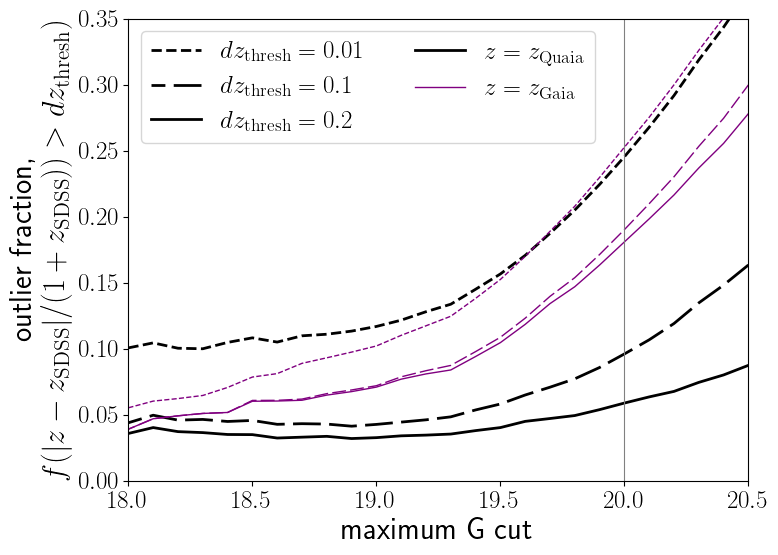

In [63]:
plt.figure(figsize=(8,6))
ax = plt.gca()

G_arr = tab_spz_labeled['phot_g_mean_mag'][i_test]
G_maxs = np.arange(18.0, 20.501, 0.1)

dz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
lss = ['--', (5, (10,3)), '-']
for iz, dz_thresh in enumerate(dz_threshs):
    n_insample = np.empty(len(G_maxs), dtype=int)
    f_outliers_spz = np.empty(len(G_maxs))
    f_outliers_gaia = np.empty(len(G_maxs))

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample[i] = np.sum(i_insample)
        
        f_outliers_spz[i] = np.sum(np.abs(dz_spz_test[i_insample]) > dz_thresh) / n_insample[i]
        f_outliers_gaia[i] = np.sum(np.abs(dz_gaia_test[i_insample]) > dz_thresh) / n_insample[i]
        
    plt.plot(G_maxs, f_outliers_spz, color='k', alpha=1, ls=lss[iz], lw=2, label=fr'$dz_\mathrm{{thresh}}={dz_thresh}$')
    plt.plot(G_maxs, f_outliers_gaia, color=color_gaia, alpha=1, ls=lss[iz], lw=1)

plt.xlabel("maximum G cut")
plt.ylabel('outlier fraction,\n' + rf'$f(|z-{abbrv_zsdss}|/(1+{abbrv_zsdss}))>dz_\mathrm{{thresh}})$')
plt.ylim(0, 0.35)
plt.xlim(np.min(G_maxs), np.max(G_maxs))


handles, labels = ax.get_legend_handles_labels()
line_spz = Line2D([], [], color='k', lw=2)
line_gaia = Line2D([], [], color=color_gaia, lw=1)
handles.extend([line_spz, line_gaia])
labels.extend([f'$z={abbrv_zspz}$', f'$z={abbrv_zgaia}$'])

plt.legend(handles, labels, ncol=2)

plt.axvline(20.0, color='grey', lw=0.8)

## new dust map

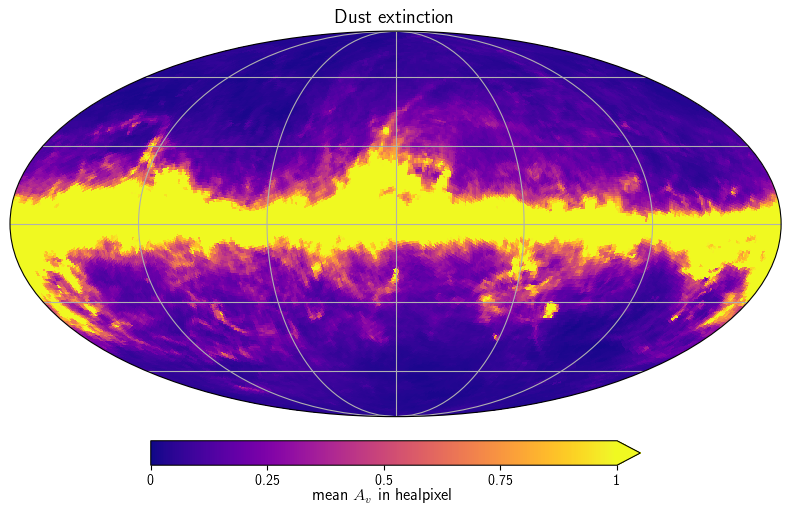

In [31]:
projview(map_dust, title=rf"Dust extinction",
         unit=r"mean $A_v$ in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=0.0, max=1.0, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
         graticule=True)

In [22]:
map_names = ['dust', 'stars', 'm10', 'mcs', 'unwise', 'unwisescan']
maps_forsel = sf.load_maps(NSIDE, map_names)

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Star map already exists, loading from ../data/maps/map_stars_NSIDE64.npy
M10 map already exists, loading from ../data/maps/map_m10_NSIDE64.npy
MCs map already exists, loading from ../data/maps/map_mcs_NSIDE64.npy
unWISE map already exists, loading from ../data/maps/map_unwise_NSIDE64.npy
unWISE scan map already exists, loading from ../data/maps/map_unwisescan_NSIDE64.npy


In [26]:
i_nonzero = map_gcatlo > 0
i_okay = sf.get_okay_pixels(map_gcatlo, map_names, maps_forsel)

25287 of pixels have okay values of all templates!
That's 0.51446533203125 of all pixels
And 0.5962930648242035 of nonzero pixels


In [27]:
tag_sel = ''
fn_sel = f"../data/maps/selection_function_NSIDE64_G20.0{tag_sel}.fits"
fn_ypred = f"../data/maps/y_pred_NSIDE64_G20.0{tag_sel}.fits"

map_ypred = hp.read_map(fn_ypred)
map_sel = hp.read_map(fn_sel)
print(np.min(map_sel), np.max(map_sel))

0.03105970552626549 0.9369050118342875


In [28]:
print('RMSE (nonzero pix):', utils.compute_rmse(map_ypred[i_nonzero], map_gcatlo[i_nonzero]), flush=True)
print('RMSE (okay pix):', utils.compute_rmse(map_ypred[i_okay], map_gcatlo[i_okay]), flush=True)

RMSE (nonzero pix): 4.367083725317927
RMSE (okay pix): 4.7721932277762065


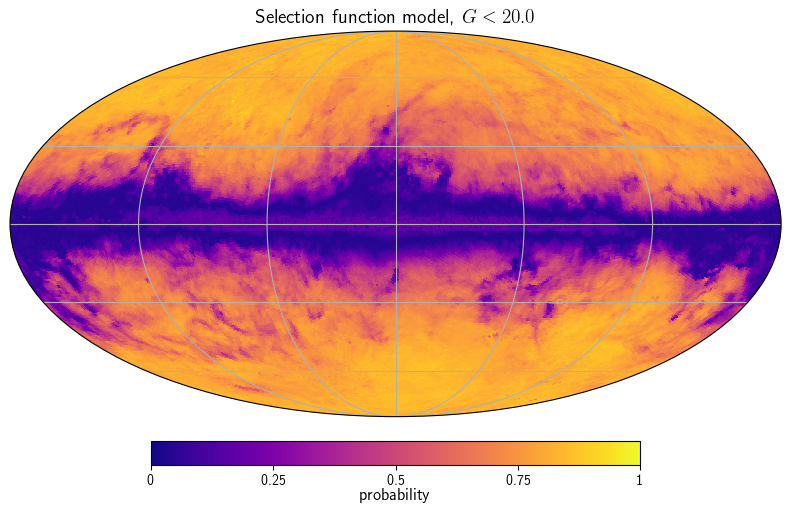

In [29]:
projview(map_sel, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True,
            cbar_ticks=[0,0.25,0.5,0.75,1.0]
            ) 

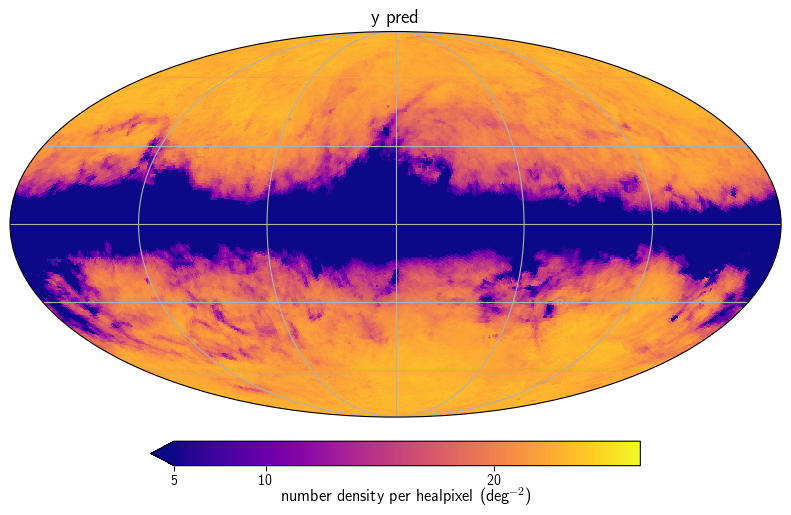

In [17]:
projview(map_ypred, title='y pred',
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_gcatlo)-np.std(map_gcatlo), max=np.median(map_gcatlo)+1.5*np.std(map_gcatlo), 
            #min=15, max=70, 
            norm='log', graticule=True,
            cbar_ticks=[5, 10, 20]) 

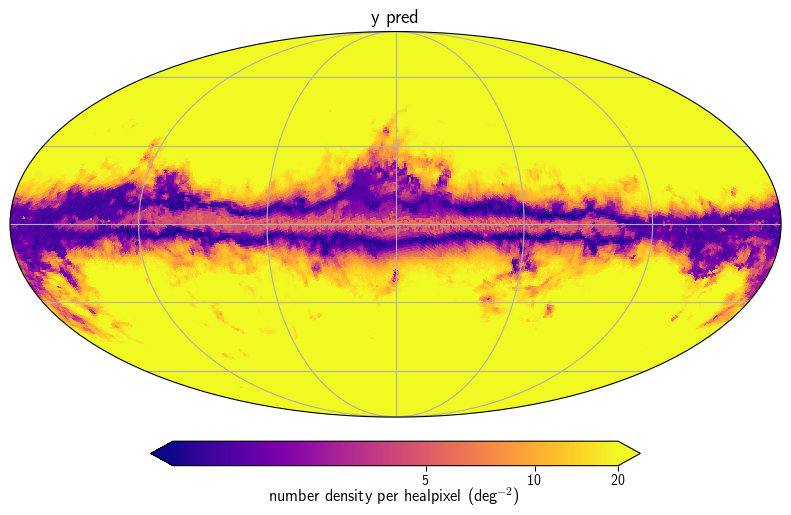

In [36]:
projview(map_ypred, title='y pred',
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=1, max=np.median(map_gcatlo), 
            #min=15, max=70, 
            norm='log', graticule=True,
            cbar_ticks=[5, 10, 20]) 

/state/partition1/job-38541571/ipykernel_1636130/2127882572.py:1: RuntimeWarning: divide by zero encountered in divide
  hp.mollview(map_ypred/map_gcatlo - 1, title=rf"Residuals (fractional)",


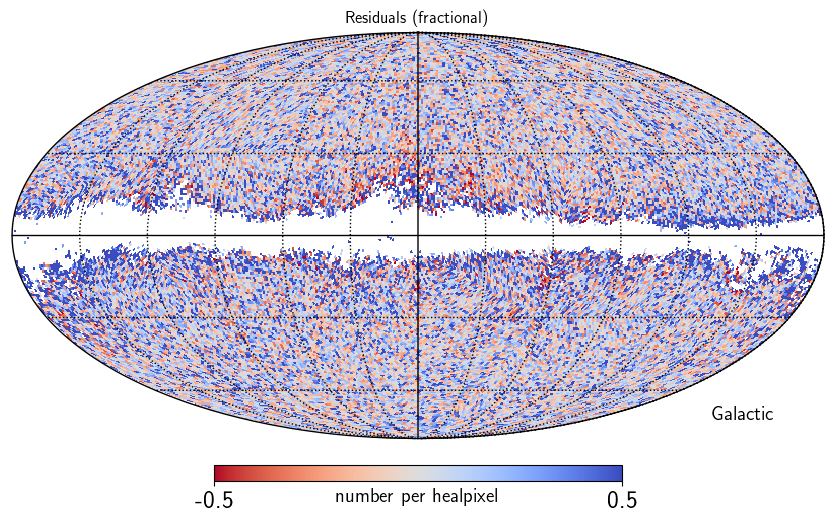

In [18]:
hp.mollview(map_ypred/map_gcatlo - 1, title=rf"Residuals (fractional)",
            unit=r"number per healpixel", cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5
            #min=-3, max=3
           )
hp.graticule()